## Q1

Computer vision is a subfield of machine learning and AI that allows computers to analyze and respond to visual information such as images and videos. This technology has become the backbone of many industries, including manufacturing, consumer goods, agriculture, medicine, and so on. The global market for computer vision was expected to reach $48.6 billion by 2022.

Computer vision systems perform tasks like image segmentation, pattern recognition, object classification, tracking and detection, and facial recognition. They work by interpreting images or videos as a series of pixels, tagged with color values, which are processed through a neural network. Computer vision dates back to the 1950s, but major strides were made with the release of ImageNet, a dataset of millions of tagged images, in 2010.

This dataset launched the development of computer vision techniques into overdrive, but it also presented various problems. Since some images in the dataset were labelled inappropriately, the models that trained on this dataset were inherently baised.  In 2019, a study revealed a prevalence of bias and problematic labels in the dataset, leading to widespread criticism. Facial recognition technology, an application of computer vision, has been known to misidentify Black people, raising serious ethical concerns.

Computer vision also faces other challenges, including hardware limitations, the complexity of scaling systems, and the need for massive amounts of computing power and data. Regulations around the technology are still emerging and often unclear, creating further obstacles for researchers and companies in the field.

## Q2

In [32]:
# Only run if need to unzip the file downloaded from Kaggle
# import zipfile
# import os

# def extract_zip_file(zip_file_path, dest_path):
#     # Ensure the destination path exists
#     if not os.path.exists(dest_path):
#         os.makedirs(dest_path)

#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(dest_path)
        

# # Use the function
# zip_file_path = 'archive.zip'  # replace with your zip file path
# dest_path = os.getcwd()  # get current working directory
# extract_zip_file(zip_file_path, dest_path)

### a

In [1]:
# Distribute load over all GPU

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def set_gpus(*gpu_indices):
    # Get list of GPUs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))

    if gpus:
        visible_gpus = [gpus[i] for i in gpu_indices]
        try:
            # Only use specified GPUs and ignore the others
            tf.config.experimental.set_visible_devices(visible_gpus, 'GPU')
            for gpu in visible_gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Using GPUs: ", [gpu.name for gpu in visible_gpus])
        except RuntimeError as e:
            print(e)
    return visible_gpus

# Call the function with the indices of the GPUs you want to use
visible_gpus = set_gpus(0, 1, 2, 3, 4)  # Use the second, third, fourth, and fifth GPU

# Extract names of the GPUs being used
gpu_names = ['/device:GPU:' + gpu.name.split(':')[-1] for gpu in visible_gpus]

strategy = tf.distribute.MirroredStrategy(devices=gpu_names)

2023-05-21 12:58:17.399115: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-21 12:58:19.777011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 12:58:25.602224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  5
Using GPUs:  ['/physical_device:GPU:0', '/physical_device:GPU:1', '/physical_device:GPU:2', '/physical_device:GPU:3', '/physical_device:GPU:4']


2023-05-21 12:58:45.689250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46671 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-05-21 12:58:45.691944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46671 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-05-21 12:58:45.692661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46671 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:88:00.0, compute capability: 8.6
2023-05-21 12:58:45.693264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46671 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:89:00.0, 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


['/device:GPU:0',
 '/device:GPU:1',
 '/device:GPU:2',
 '/device:GPU:3',
 '/device:GPU:4']

In [2]:
# Load the .txt file as a pandas DataFrame
def load_labels(file_path):
    df = pd.read_csv(file_path, sep=" ", header=None)
    df.columns = ["filename", "target"]
    df['filename'] = df.apply(lambda row: os.path.join(str(row['target']), row['filename']), axis=1)
    df["target"] = df["target"].astype(str)
    df['filename'] = df['filename'].astype(str)  # Convert class column to string type
    return df

train_df = load_labels("train.txt")
test_df = load_labels("test.txt")
val_df = load_labels("val.txt")

In [11]:
batch_size = 128
img_height = 64
img_width = 64

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df, directory="classification/train", 
                                                    x_col="filename", y_col="target",
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='categorical')

validation_generator = train_datagen.flow_from_dataframe(val_df, directory="classification/val", 
                                                         x_col="filename", y_col="target",
                                                         target_size=(img_height, img_width), 
                                                         batch_size=batch_size, class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(test_df, directory="classification/test", 
                                                  x_col="filename", y_col="target", 
                                                  target_size=(img_height, img_width), 
                                                  batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 45095 validated image filenames belonging to 102 classes.
Found 7508 validated image filenames belonging to 102 classes.
Found 22619 validated image filenames belonging to 102 classes.


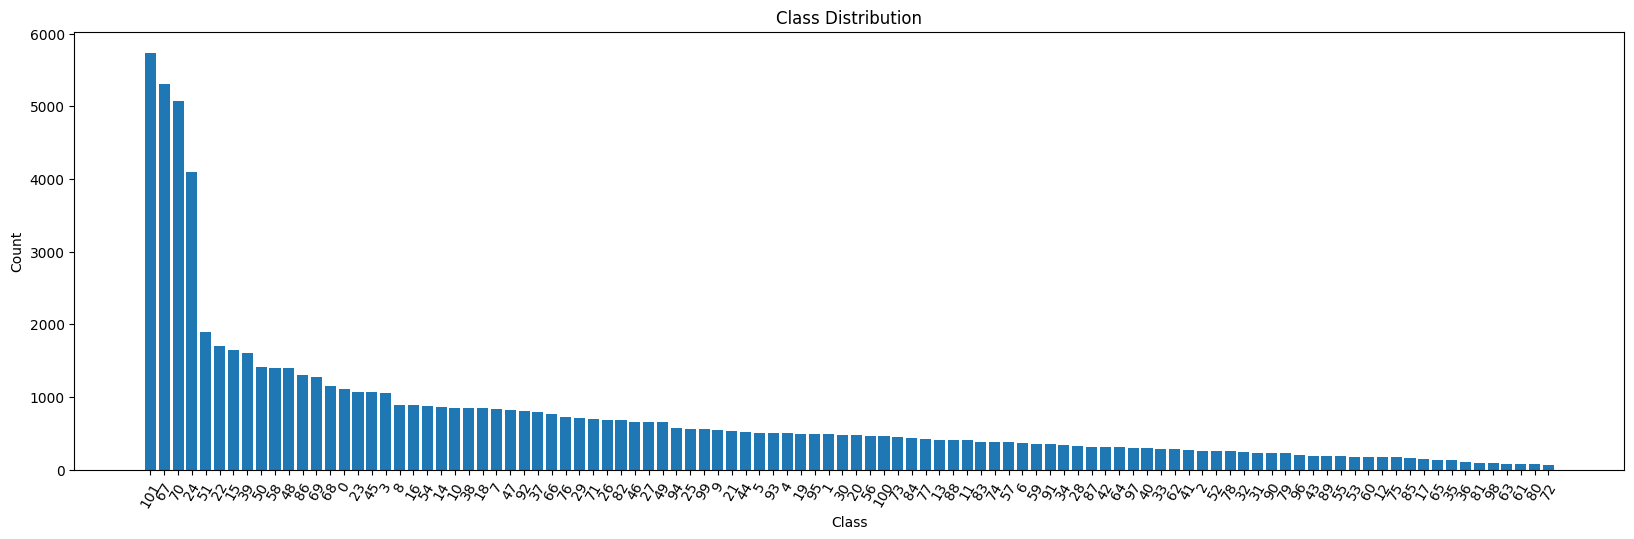

In [17]:
all_labels = pd.concat([train_df, test_df, val_df], axis = 0)
class_dist = all_labels.target.value_counts()
plt.figure(figsize=(20,6))
plt.bar(class_dist.index, class_dist.values)
plt.tick_params(axis='x', which='major', labelsize=10)  # Change label size to 10
plt.xticks(range(len(class_dist.index)), class_dist.index, rotation=60)
plt.subplots_adjust(bottom=0.15)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

### b

In [12]:
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

def create_model(input_shape, optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']):
    model = Sequential([
        Conv2D(32, (3,3), activation = 'relu', input_shape = (input_shape[0], input_shape[1], 3), kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(64, (3,3), activation = 'relu', kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Flatten(),
        Dense(1024, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(102, activation='softmax') #102 classes

    ])

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [13]:
tf.test.is_gpu_available()


2023-05-21 13:13:18.743605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 46671 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-05-21 13:13:18.744262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:1 with 46671 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-05-21 13:13:18.744836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:2 with 46671 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:88:00.0, compute capability: 8.6
2023-05-21 13:13:18.745426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:3 with 46671 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:89:00.0, compute capability: 8.6
2023-05-21 13:13:18.745933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device 

True

In [14]:
with strategy.scope():
    m1 = create_model((img_height, img_width))
    history = m1.fit(train_generator, epochs = 100, validation_data = validation_generator)

2023-05-21 13:13:25.507074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-21 13:13:25.507287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-21 13:13:25.508117: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_

Epoch 1/100


2023-05-21 13:13:34.506115: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


184/353 [==============>...............] - ETA: 1:44 - loss: 4.3817 - accuracy: 0.1155

KeyboardInterrupt: 

In [31]:
# So i dont have to retrain model if i repoen this file.
m1.save("model_1.h5")

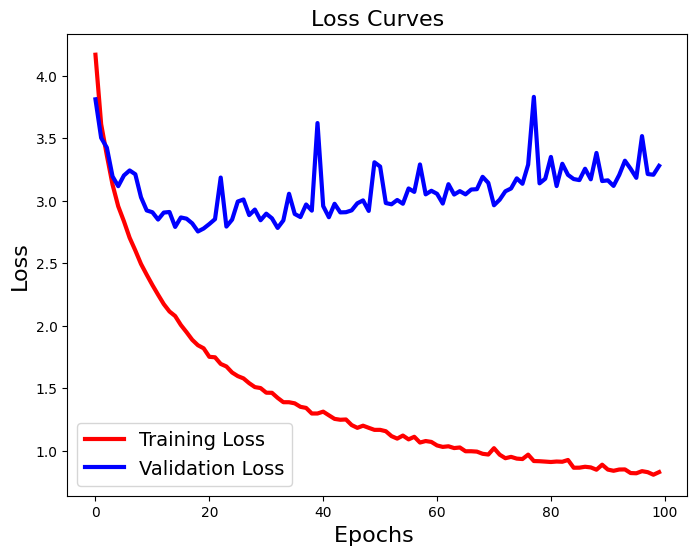

In [33]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

Architecture:
- There are 2 convolution blocks followed by a fully connected layer and an output layer. 
- In each convolution block, there is a convolution layer, a max pooling layer, a batch normalization process, L1 and L2 regularization, and a dropout process.
- The output layer has 102 neurons as there are 102 classes in the dataset.

Hyperparameters:
- Number of filters: There are 32 filters in the first convolution layer, and 64 filters in the second convolution layer. 32 filters is a good starting point for the first layer, but as the CNN gets deeper, more filters are needed to capture more complicated features, such as textures, patterns, and shapes.
- Filter size: (3,3). This filter size is a common choice in many CNNs. If the filter is too small it might not be able to capture enough information, and if the filter is too large, it can increase computational expense and cause the model to miss out on local features.
- Pooling size: (2,2). This "filter" size is common for max pooling layers, where we scale down the input in a 2x2 window to only the largest value within that window. This reduces the spatial dimensions of the data and increases the compute efficiency.
- Dropout: Neurons are turned off randomly with a probability of 0.25. During test-time, the output of these neurons that were turned off are scaled by 1/(1-0.25). This not only helps prevent overfit when training, it also allows the full architecture to be utilized during testing.
- Dense layer: 1024 neurons. Since the task is fairly complicated, it is reasonable to use more neurons in the dense layer. More neurons can help th emodel learn more complex patterns, but can increase complexity.
- Output layer: There are 102 neurons as there are 102 classes we want to predict.

Number of parameters
- (filter_height * filter_width * input_image_channels + 1) * number_of_filters
- Thus, for the first convolution layer: (3x3x3+1)x32 = 896. For the second convolution layer: (3x3x3+1)x64 = 1792.

### c

In [35]:
from keras.applications import ResNet50, DenseNet121, EfficientNetB0

# Define model to transfer learn from 
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64,64,3))

# Freeze the layers of base models
for layer in base_model.layers:
    layer.trainable = False

# Create new models with the frozen base models and new top layers
transfer_model = Sequential()
transfer_model.add(base_model)
transfer_model.add(Flatten())
transfer_model.add(Dense(256, activation='relu'))
transfer_model.add(BatchNormalization())
transfer_model.add(Dropout(0.25))
transfer_model.add(Dense(102, activation='softmax'))

# Earlystop
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_transfer = transfer_model.fit(train_generator, epochs = 100, validation_data = validation_generator, callbacks = [callback])

Epoch 1/100


2023-05-20 20:57:07.656961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-20 20:57:09.755823: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1409/1410 [============================>.] - ETA: 0s - loss: 4.2606 - accuracy: 0.0708

2023-05-20 20:58:07.237414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1410/1410 [==============================] - 69s 47ms/step - loss: 4.2607 - accuracy: 0.0708 - val_loss: 4.1555 - val_accuracy: 0.0765
Epoch 2/100
1410/1410 [==============================] - 66s 47ms/step - loss: 4.1790 - accuracy: 0.0781 - val_loss: 4.1328 - val_accuracy: 0.0790
Epoch 3/100
1410/1410 [==============================] - 65s 46ms/step - loss: 4.1565 - accuracy: 0.0834 - val_loss: 4.1297 - val_accuracy: 0.0730
Epoch 4/100
1410/1410 [==============================] - 65s 46ms/step - loss: 4.1364 - accuracy: 0.0905 - val_loss: 4.1077 - val_accuracy: 0.1062
Epoch 5/100
1410/1410 [==============================] - 65s 46ms/step - loss: 4.1198 - accuracy: 0.0942 - val_loss: 4.1748 - val_accuracy: 0.0796
Epoch 6/100
1410/1410 [==============================] - 65s 46ms/step - loss: 4.1123 - accuracy: 0.0954 - val_loss: 4.0945 - val_accuracy: 0.1064
Epoch 7/100
1410/1410 [==============================] - 65s 46ms/step - loss: 4.1082 - accuracy: 0.0954 - val_loss: 4.1900 - val_

As seen above, the custom model with 2 convolution blocks outperformed the transfer leanring model using EfficientNet. This might be because the custom CNN was trained completely on the IP 102 dataset, which means that the weights of that model are optimized for the task. The EfficientNet model used as a base for transfer learning was trained using ImageNet dataset, which might not be as specialized as using just the IP 102 dataset.

## Q3

In [19]:
from tensorflow.keras.layers import LSTM
import numpy as np

# Data
x_train = np.random.uniform(-np.pi, np.pi, 1000)
y_train = np.sin(x_train)
x_test = np.linspace(-np.pi, np.pi, 100)

# Reshape the data to (samples, timesteps, features)
sequence_length = 10
x_train_rnn = np.array([x_train[i:i+sequence_length] for i in range(len(x_train)-sequence_length)])
y_train_rnn = y_train[sequence_length:]
x_test_rnn = np.array([x_test[i:i+sequence_length] for i in range(len(x_test)-sequence_length)])

# Reshape to (samples, timesteps, features)
x_train_rnn = x_train_rnn.reshape((-1, sequence_length, 1))
x_test_rnn = x_test_rnn.reshape((-1, sequence_length, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length,1)),
    Dense(1) # Regression
])
model_lstm.compile(optimizer='adam', loss='mse')

# GRU
model_gru = Sequential([
    tf.keras.layers.GRU(50, activation='relu', input_shape=(sequence_length,1)),
    tf.keras.layers.Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')

# MLP (ordinary NN)
model_mlp = Sequential([
    Dense(16, activation='relu', input_dim=1),
    Dense(16, activation = 'relu'),
    Dense(1, activation='linear')
])
model_mlp.compile(optimizer='adam', loss='mse')

In [22]:
# Earlystop
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# LSTM
history_lstm = model_lstm.fit(x_train_rnn, y_train_rnn, epochs = 100, callbacks=[callback])
y_pred_lstm = model_lstm.predict(x_test_rnn)

# GRU
history_gru = model_gru.fit(x_train_rnn, y_train_rnn, epochs = 100, callbacks=[callback])
y_pred_gru = model_gru.predict(x_test_rnn)

# MLP
history_mlp = model_mlp.fit(x_train, y_train, epochs = 100, callbacks=[callback])
y_pred_mlp = model_mlp.predict(x_test)

Epoch 1/100
31/31 [==============================] - 1s 31ms/step - loss: 0.4974
Epoch 2/100
31/31 [==============================] - 1s 31ms/step - loss: 0.4967
Epoch 3/100
31/31 [==============================] - 1s 32ms/step - loss: 0.4967
Epoch 4/100
31/31 [==============================] - 1s 32ms/step - loss: 0.4967
Epoch 5/100
31/31 [==============================] - 1s 32ms/step - loss: 0.4968
Epoch 6/100
3/3 [==============================] - 0s 7ms/step
Epoch 1/100
31/31 [==============================] - 3s 40ms/step - loss: 0.5029
Epoch 2/100
31/31 [==============================] - 1s 40ms/step - loss: 0.5004
Epoch 3/100
31/31 [==============================] - 1s 42ms/step - loss: 0.5014
Epoch 4/100
31/31 [==============================] - 1s 42ms/step - loss: 0.4988
Epoch 5/100
31/31 [==============================] - 1s 40ms/step - loss: 0.4983
Epoch 6/100
31/31 [==============================] - 1s 40ms/step - loss: 0.4974
Epoch 7/100
31/31 [===========================

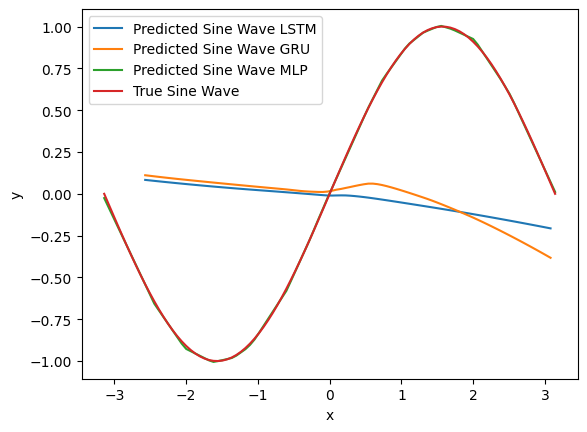

In [27]:
x_test_flattened = x_test_rnn[:,-1,0]

plt.plot(x_test_flattened, y_pred_lstm.flatten(), label='Predicted Sine Wave LSTM')
plt.plot(x_test_flattened, y_pred_gru.flatten(), label='Predicted Sine Wave GRU')
plt.plot(x_test, y_pred_mlp, label='Predicted Sine Wave MLP')
plt.plot(x_test, np.sin(x_test), label='True Sine Wave')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()